Importing libraries
    1. numpy and pandas for data processing
    2. re for regular expressions in data pre-processing
    3. nltk for stopword lis, POS tagging and negation marking
    4. seaborn for drawing confusion matrices

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import seaborn as sns
from nltk.sentiment import util
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Michal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
#Sentiment mapping

#maps 5-value score to 3 value score
def five2three(score):
    if score == 4 or score == 3:
        return 2
    elif score == 2:
        return 1
    elif score == 1 or score == 0:
        return 0

In [3]:
#Load datasets

#load datasets with 5-value scale
train5 = pd.read_csv('moviereviews/train.tsv', sep='\t')
dev5 = pd.read_csv('moviereviews/dev.tsv', sep='\t')
test = pd.read_csv('moviereviews/test.tsv', sep='\t')

#create datasets with 3-value scale
train3 = train5.copy()
train3.Sentiment = train3.Sentiment.apply(five2three)
dev3 = dev5.copy()
dev3.Sentiment = dev3.Sentiment.apply(five2three)

Model class

In [4]:
class Model:
    """Class representing a model"""
    
    def __init__(self, train_data, scale, feature_selection=None):
        """Constructor
        
        Args:
            train_data        (pandas.DataFrame): data from which model is trained
            scale             (int): scale for classification (3 or 5)
            feature_selection (function): function to be performed on extracted features
        """
        self.scale = scale
        # extract all words from training set as features
        self.features = self.extract_words(train_data, scale)
        # calculate priors
        self.priors = self.calc_priors(train_data, scale)
        
        # if function for feature selection passed, perform feature selection
        if feature_selection != None:
            self.features = feature_selection(self.features)
    
    
    def calc_priors(self, train_data, scale):
        total = train_data.shape[0]
        sentiment_count = train_data.groupby(by='Sentiment').count()
        priors = np.zeros(scale)
        for i in range(scale):
            priors[i] = sentiment_count.iloc[i][0] / total
        
        return priors
    
    
    def extract_words(self, df, scale):
        all_words = {}
    
        for row in df.itertuples(index=False, name=None):
            sentiment = row[2]
            words = row[1].split(' ')
    
            for word in words:
                if word == '' or word == ' ':
                    continue
            
                if word not in all_words:
                    if scale == 3:
                        all_words[word] = {'q': 1, 0: 0, 1: 0, 2: 0}
                    else:
                        all_words[word] = {'q': 1, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
                    all_words[word][sentiment] = 1
                else:
                    all_words[word]['q'] += 1
                    if sentiment in all_words[word]:
                        all_words[word][sentiment] += 1
                    else:
                        all_words[word][sentiment] = 1
        
        #turn the dictionary into dataframe
        words_df = pd.DataFrame.from_dict(all_words, orient="index")
        
        #count distinct features for each sentiment
        distinct_features = np.zeros(scale)
        for i in range(scale):
            features_in_sentiment = words_df[i] > 0
            distinct_features[i] = words_df[features_in_sentiment].shape[0]
    
        #apply Laplace smoothing
        for i in range(scale):
            words_df[i] = (words_df[i] + 1) / (distinct_features[i] + words_df.shape[0])
    
        return words_df

Functions used for classification

In [5]:
def classify_set(dataset, model):
    """Predicts sentiment of samples in given dataset
    
    Args:
        dataset (pandas.DataFrame): dataset to be classified
        model   (Model): model to be used
    """
    sentenceIds = []
    true = []
    predicted = []
    for row in dataset.itertuples(index=None, name=None):
        sentenceIds.append(row[0])
        prediction = classify_sentence(row[1], model)
        if (len(row) > 2):
            true.append(row[2])
        predicted.append(prediction)
    
    # build result dataframe
    results = {'sentence_id': sentenceIds,
               'sentiment_value': predicted}
    
    results_df = pd.DataFrame(results, columns = ['sentence_id', 'sentiment_value'], index=None)
    
    if len(true) > 1:
        return results_df, true, predicted
    else:
        return results_df
        
        
#classifies a single sentence
def classify_sentence(sentence, model):
    """Predicts sentiment of a single sentence
    
    Args:
        sentence (string): The string to be classified
        model    (Model): model to be used
    """
    words = sentence.split(' ')
    
    p = np.copy(model.priors)
    
    for word in words:
        if word in model.features.index:
            row = model.features.loc[word]
            for i in range(model.scale):
                p[i] *= row[i]
                
    return np.argmax(p)
    

def build_cf(true, predicted, scale):
    """Creates a confusion matrix
    Args:
        true      (list): list of true labels
        predicted (list): list of labels predicted by the model
        scale     (int): scale for the classification (3 or 5)
    """
    print('Accuracy:', get_accuracy(true,predicted), '%')
    cf = np.zeros((scale, scale))
    
    for i in range(len(true)):
        cf[predicted[i]][true[i]] += 1
        
    sns.heatmap(cf, annot=True, fmt='g')


def get_accuracy(true, predicted):
    """Calculates accuracy of predictions"""
    correct = 0
    for i in range(len(true)):
        if true[i] == predicted[i]:
            correct += 1
    
    return round((correct / len(true)) * 100, 2)

Classification with all words, no pre-processing
5-value scale
Accuracy: 39.0 %


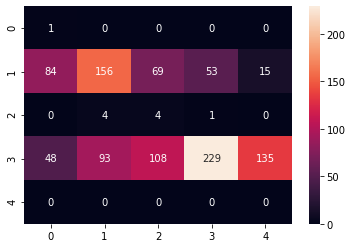

In [6]:
model_base_5 = Model(train5, 5)

print('Classification with all words, no pre-processing')
print('5-value scale')
result, true, predicted = classify_set(dev5, model_base_5)

build_cf(true, predicted, model_base_5.scale)

Classification with all words, no pre-processing
3-value scale
Accuracy: 62.2 %


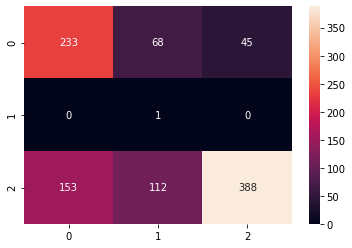

In [7]:
model_base_3 = Model(train3, 3)

result, true, predicted = classify_set(dev3, model_base_3)

print('Classification with all words, no pre-processing')
print('3-value scale')
build_cf(true, predicted, model_base_3.scale)

Data pre-processing

In [8]:
train5_processed = train5.copy()
dev5_processed = dev5.copy()

In [9]:
#Lowercaing
train5_processed.Phrase = train5_processed.Phrase.str.lower()
dev5_processed.Phrase = dev5_processed.Phrase.str.lower()
test.Phrase = test.Phrase.str.lower()

In [10]:
#Mark negated words
affected_pos = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS']

def markNegatedWords(phrase):
    old = phrase.split()
    old_tagged = nltk.pos_tag(old)
    new = nltk.sentiment.util.mark_negation(old)
    final = []
    for i in range(len(new)):
        if old_tagged[i][1] in affected_pos:
            final.append(new[i])
        else:
            final.append(old[i])
            
    return ' '.join(final)

train5_processed.Phrase = train5_processed.Phrase.apply(markNegatedWords)
dev5_processed.Phrase = dev5_processed.Phrase.apply(markNegatedWords)
test.Phrase = test.Phrase.apply(markNegatedWords)

In [11]:
to_remove = [',', '.', '\'', '\"', '!', '?', ':']

#Noise removal
def removeNoise(phrase):    
    new = [word for word in phrase.split(' ') if word not in to_remove]
    return ' '.join(new)


train5_processed.Phrase = train5_processed.Phrase.apply(removeNoise)
dev5_processed.Phrase = dev5_processed.Phrase.apply(removeNoise)
test.Phrase = test.Phrase.apply(removeNoise)

In [12]:
#Stop-word removal
stop = stopwords.words('english')

def removeStopWords(phrase):    
    new = [word for word in phrase.split(' ') if word not in stop]
    return ' '.join(new)
    

train5_processed.Phrase = train5_processed.Phrase.apply(removeStopWords)
dev5_processed.Phrase = dev5_processed.Phrase.apply(removeStopWords)
test.Phrase = test.Phrase.apply(removeStopWords)

In [13]:
#create datasets with 3-value scale
train3_processed = train5_processed.copy()
train3_processed.Sentiment = train3_processed.Sentiment.apply(five2three)
dev3_processed = dev5_processed.copy()
dev3_processed.Sentiment = dev3_processed.Sentiment.apply(five2three)

Classification results for pre processed data

Classification with all words and pre-processing
5-value scale
Accuracy: 40.7 %


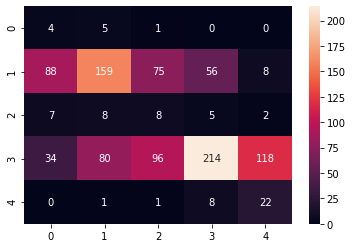

In [14]:
model_processed_5 = Model(train5_processed, 5)

print('Classification with all words and pre-processing')
print('5-value scale')
result, true, predicted = classify_set(dev5_processed, model_processed_5)

#result.to_csv('dev_predictions_5classes_Michal_JARMOCIK.tsv',sep='\t')

build_cf(true, predicted, model_processed_5.scale)

Classification with all words and pre-processing
3-value scale
Accuracy: 65.0 %


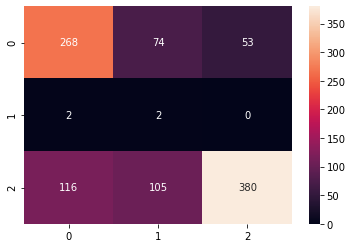

In [15]:
model_processed_3= Model(train3_processed, 3)

print('Classification with all words and pre-processing')
print('3-value scale')
result, true, predicted = classify_set(dev3_processed, model_processed_3)
#result.to_csv('dev_predictions_3classes_Michal_JARMOCIK.tsv',sep='\t')

build_cf(true, predicted, model_processed_3.scale)

In [16]:
print("Second model features")
model_processed_3.features

Second model features


,q,0,1,2
series,43,0.000915,0.000305,0.000567
escapades,1,0.000076,0.000044,0.000038
demonstrating,3,0.000114,0.000044,0.000076
adage,3,0.000076,0.000044,0.000113
good,181,0.001830,0.001571,0.003781
...,...,...,...,...
low-wattage,1,0.000076,0.000044,0.000038
shiver,1,0.000038,0.000087,0.000038
reviewed,1,0.000038,0.000087,0.000038
deliberateness,1,0.000076,0.000044,0.000038


In [17]:
#Test set classification
#result = classify_set(test, model_processed_5)
#result.to_csv('test_predictions_5classes_Michal_JARMOCIK.tsv',sep='\t')

#result = classify_set(test, model_processed_3)
#result.to_csv('test_predictions_3classes_Michal_JARMOCIK.tsv',sep='\t')

Classification with feature selection

In [18]:
# creating function for selecting a subset of features carrying most information

def feature_selection(features):
    # calculate variance for each feature
    features['var'] = features.apply(lambda x: np.var(x.values[1:]), axis=1)
    
    # select features with variance higher than cut off value
    var_cutoff = 0.000000001
    high_var =  features['var'] > var_cutoff
    
    # select features wich are present in dataset at least twice
    high_count = features['q'] > 1
    
    return features[high_var & high_count]

Classification with subset of words and pre-processing
5-value scale
Accuracy: 39.9 %


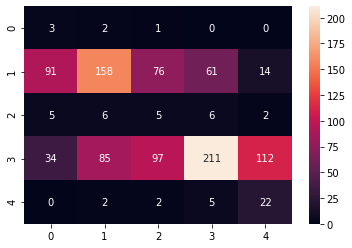

In [19]:
model_final_5 = Model(train5_processed, 5, feature_selection)

print('Classification with subset of words and pre-processing')
print('5-value scale')
result, true, predicted = classify_set(dev5_processed, model_final_5)
build_cf(true, predicted, model_final_5.scale)

Classification with subset of words and pre-processing
3-value scale
Accuracy: 63.7 %


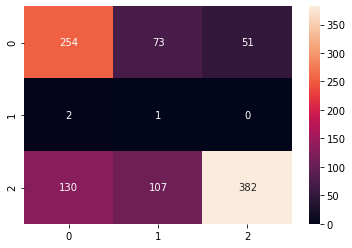

In [20]:
model_final_3 = Model(train3_processed, 3, feature_selection)

print('Classification with subset of words and pre-processing')
print('3-value scale')
result, true, predicted = classify_set(dev3_processed, model_final_3)
build_cf(true, predicted, model_final_3.scale)

In [21]:
print('Final model features')
model_final_3.features

Final model features


,q,0,1,2,var
series,43,0.000915,0.000305,0.000567,6.232642e-08
good,181,0.001830,0.001571,0.003781,9.731701e-07
goose,3,0.000114,0.000087,0.000038,1.004653e-09
also,100,0.000953,0.000916,0.002155,3.312308e-07
occasionally,27,0.000343,0.000393,0.000454,2.046479e-09
...,...,...,...,...,...
drown,2,0.000114,0.000044,0.000038,1.210918e-09
exploiting_NEG,2,0.000114,0.000044,0.000038,1.210918e-09
pore,2,0.000114,0.000044,0.000038,1.210918e-09
numbered,2,0.000038,0.000044,0.000113,1.174760e-09
